# Partial Configuration Identification


We consider performance analysis in highly variable systems, such as x264, with a large number of configurations options and input features, and multiple performance metrics.
Our goal in this work to identify partial stable configurations from a set of measurements.
A stable configuration is a configuration that is consistently high performing, indicated by its presence in the Pareto front of configurations for each of the videos in the measurement set.
In the ideal case, we identify a single configuration that is present in every Pareto front, i.e. it is never dominated by another configuration. This would be the premier configuration to test for every new input.
Otherwise, we can identify the subset of configurations options that most frequently occur together and propose these as a partial configuration. The extensions of this partial configuration can then form a reduced set of candidate configurations to consider for evaluation/application. The extensions can be similarly determined from the obtained measurements and potentially be weighted by their expected performance resp. their influence on certain performance metrics.

We raise the following research questions:
- Do stable configurations exist? Are they partial or full configurations?
- Do the best configurations share common parameters?
- What is the largest common set of parameters with minimum quality?
- How much do the results vary if we further partition the data, e.g. by video category?
   
Technically speaking, we can apply techniques from data mining, e.g. frequent itemset mining, to determine the core partial configurations, but we do not have to rely on complex statistical machine learning techniques, which makes this approach simple and interpretable.
    
We present an in-depth analysis of our approach on a large-scale dataset of video encodings using the x264 video encoder.
Additionally, we confirm the applicability of our approach on seven others configurable systems (Luc's dataset: gcc, imagemagick, lingeling, nodeJS, poppler, SQLite, xz).

First we import some packages.
`common` is our shared library for shared functions like loading, ranking, etc.

In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
from scipy import stats
from common import load_data, pareto_rank
import os
import json

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import fpgrowth, fpmax

We load the data for one system, here `x264`.

In [2]:
random_state = 1234
test_size = 0.2
pareto_cutoff = 0.4
(
    perf_matrix,
    input_features,
    config_features,
    all_performances,
    input_preprocessor,
    config_preprocessor,
) = load_data(system="x264", data_dir="../data", input_properties_type="tabular")

# Normalization is needed for the Pareto cutoff
# We can normalize before splitting, because
# we normalize per input and we also split per input.
# There is no data leakage.
normalized_metrics = (
    perf_matrix[["inputname"] + all_performances]
    .groupby("inputname", as_index=False)
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)
cutoff_mask = (normalized_metrics <= pareto_cutoff).all(axis=1)

nmdf = perf_matrix[["inputname"] + all_performances].groupby("inputname", as_index=True).transform(lambda x: (x - x.min()) / (x.max() - x.min()))
perf_matrix = pd.merge(perf_matrix, nmdf, suffixes=("_raw", None), left_index=True, right_index=True)

all_perf_raw = [f"{p}_raw" for p in all_performances]
all_perf_norm = [f"{p}" for p in all_performances]

train_inp, test_inp = train_test_split(
    perf_matrix["inputname"].unique(),
    test_size=test_size,
    random_state=random_state,
)
train_perf = perf_matrix[perf_matrix.inputname.isin(train_inp)]
test_perf = perf_matrix[perf_matrix.inputname.isin(test_inp)]

all_performances

['size', 'etime', 'cpu', 'fps', 'kbs']

In [3]:
perf_matrix

,configurationID,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,...,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,ORIG_SIZE,ORIG_BITRATE,rel_kbs,size,etime,cpu,fps,kbs
180297,1,0,1,0:0:0,0:0,dia,0,0,16,0,...,0.017,0.005,1866272605,745763278,2.159801e-07,0.070142,0.003932,0.087486,0.111274,0.070137
180408,2,1,1,1:0:0,0x3:0x3,dia,1,0,16,0,...,0.017,0.005,1866272605,745763278,1.386767e-07,0.029658,0.066841,0.148394,0.320067,0.029654
180420,3,1,1,1:0:0,0x3:0x113,hex,2,0,16,0,...,0.017,0.005,1866272605,745763278,8.541584e-08,0.001764,0.090433,0.239203,0.380513,0.001763
180431,4,1,2,1:0:0,0x3:0x113,hex,4,0,16,0,...,0.017,0.005,1866272605,745763278,9.820811e-08,0.008462,0.098296,0.338870,0.409918,0.008462
180442,5,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,0.017,0.005,1866272605,745763278,9.407811e-08,0.006305,0.094364,0.320044,0.404663,0.006299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94777,197,1,16,1:0:0,0x3:0x133,tesa,7,1,24,2,...,11.794,0.415,828089552,331457333,1.328355e-05,0.141975,0.723088,0.866546,0.988177,0.141973
94778,198,1,16,1:0:0,0x3:0x133,hex,11,1,24,2,...,11.794,0.415,828089552,331457333,1.218320e-05,0.074812,0.583593,0.532011,0.978303,0.074811
94779,199,1,16,1:0:0,0x3:0x3,tesa,11,1,24,2,...,11.794,0.415,828089552,331457333,1.240742e-05,0.088498,0.836276,0.981064,0.993914,0.088497
94780,200,1,16,1:0:0,0:0,tesa,11,1,24,2,...,11.794,0.415,828089552,331457333,1.240742e-05,0.088498,0.809277,1.000000,0.992678,0.088497


In [4]:
input_features

,resolution,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,category
inputname,,,,,,,,
Animation_1080P-01b3,1080,1920,1080,0.098,0.004,0.017,0.005,Animation
Animation_1080P-05f8,1080,1920,1080,1.229,0.454,15.962,0.794,Animation
Animation_1080P-0c4f,1080,1920,1080,1.714,0.136,9.048,0.000,Animation
Animation_1080P-0cdf,1080,1920,1080,1.330,0.451,3.677,0.181,Animation
Animation_1080P-18f5,1080,1920,1080,2.452,0.137,3.918,0.329,Animation
...,...,...,...,...,...,...,...,...
Vlog_720P-561e,720,1280,720,2.188,0.034,1.128,0.390,Vlog
Vlog_720P-5d08,720,732,720,4.128,0.285,2.126,0.248,Vlog
Vlog_720P-60f8,720,1280,720,1.554,0.344,2.466,0.250,Vlog


In [5]:
config_features

,cabac,ref,subme,mixed_ref,me_range,trellis,8x8dct,fast_pskip,chroma_qp_offset,bframes,...,analyse,me,direct,deblock,b_adapt,b_pyramid,open_gop,rc_lookahead,scenecut,weightb
configurationID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,16,0,0,1,0,0,...,0:0,dia,NaN,0:0:0,NaN,NaN,NaN,NaN,0.0,NaN
2,1,1,1,0,16,0,1,1,0,3,...,0x3:0x3,dia,auto,1:0:0,1.0,2.0,0.0,NaN,40.0,1.0
3,1,1,2,0,16,0,1,1,0,3,...,0x3:0x113,hex,auto,1:0:0,1.0,2.0,0.0,10.0,40.0,1.0
4,1,2,4,0,16,0,1,1,0,3,...,0x3:0x113,hex,auto,1:0:0,1.0,2.0,0.0,20.0,40.0,1.0
5,1,2,6,1,16,1,1,1,-2,3,...,0x3:0x113,hex,auto,1:0:0,1.0,2.0,0.0,30.0,40.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,1,16,7,1,24,2,1,0,-2,16,...,0x3:0x133,tesa,spatial,1:0:0,2.0,2.0,0.0,60.0,40.0,1.0
198,1,16,11,1,24,2,1,0,-2,16,...,0x3:0x133,hex,spatial,1:0:0,2.0,2.0,0.0,60.0,40.0,1.0
199,1,16,11,1,24,2,1,0,-2,16,...,0x3:0x3,tesa,spatial,1:0:0,2.0,2.0,0.0,60.0,40.0,1.0


## Pareto Front Calculation

We take the matrix of all measurements and calculate the Pareto ranks for each configuration per input. For this, we consider all measured performances, but we can change this to any subset.

In [6]:
performances = ["fps", "cpu"]
performances = ["size", "etime"]
icm = (
    train_perf[["inputname", "configurationID"] + performances]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_ranked_measures = icm.groupby(
    "inputname"
).transform(  # Go from measured values to ranks within each input group
    lambda x: stats.rankdata(x, method="min")
)

# TODO Adjust pareto_rank with cutoff
# 1. Second version that ranks dominated configurations by their "dominators"
# 2. 
icm["ranks"] = icm.groupby("inputname", group_keys=False).apply(pareto_rank)

# Calculate the Pareto ranks for the test data
icm_test = (
    test_perf[["inputname", "configurationID"] + performances]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_test["ranks"] = icm_test.groupby("inputname", group_keys=False).apply(pareto_rank)

icm

size     etime  ranks
inputname            configurationID                           
Animation_1080P-01b3 1                0.070142  0.003932      3
                     2                0.029658  0.066841      4
                     3                0.001764  0.090433      3
                     4                0.008462  0.098296      8
                     5                0.006305  0.094364      7
...                                        ...       ...    ...
Vlog_720P-6d56       197              0.141975  0.723088     14
                     198              0.074812  0.583593      9
                     199              0.088498  0.836276     14
                     200              0.088498  0.809277     11
                     201              0.209511  0.752510     22

[206829 rows x 3 columns]

In [7]:
normalized_metrics

,size,etime,cpu,fps,kbs
180297,0.070142,0.003932,0.087486,0.111274,0.070137
180408,0.029658,0.066841,0.148394,0.320067,0.029654
180420,0.001764,0.090433,0.239203,0.380513,0.001763
180431,0.008462,0.098296,0.338870,0.409918,0.008462
180442,0.006305,0.094364,0.320044,0.404663,0.006299
...,...,...,...,...,...
94777,0.141975,0.723088,0.866546,0.988177,0.141973
94778,0.074812,0.583593,0.532011,0.978303,0.074811
94779,0.088498,0.836276,0.981064,0.993914,0.088497
94780,0.088498,0.809277,1.000000,0.992678,0.088497


For quick visualization, we plot the distribution of measurements and their ranks for one input.
The first Pareto front is in the lower left corner.

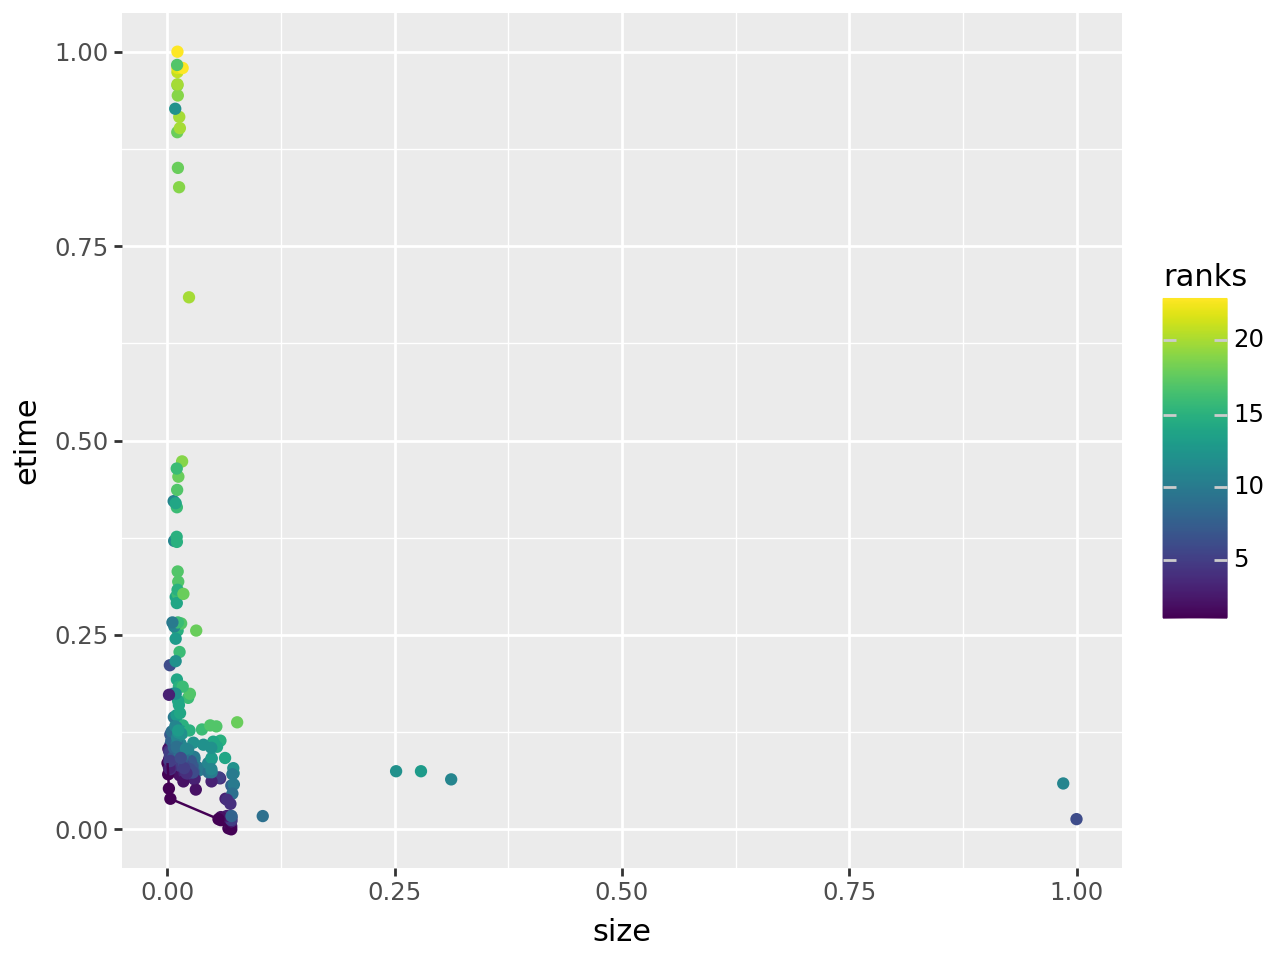

In [8]:
inputname = icm.iloc[0].name[0]
(
    p9.ggplot(icm.loc[(inputname)], p9.aes(x="size", y="etime", color="ranks"))
    + p9.geom_point()
    + p9.geom_line(icm[icm.ranks == 1].loc[(inputname)])
)

Let's look at the distribution of the ranks. How many ranks are there and how large are they over all inputs?

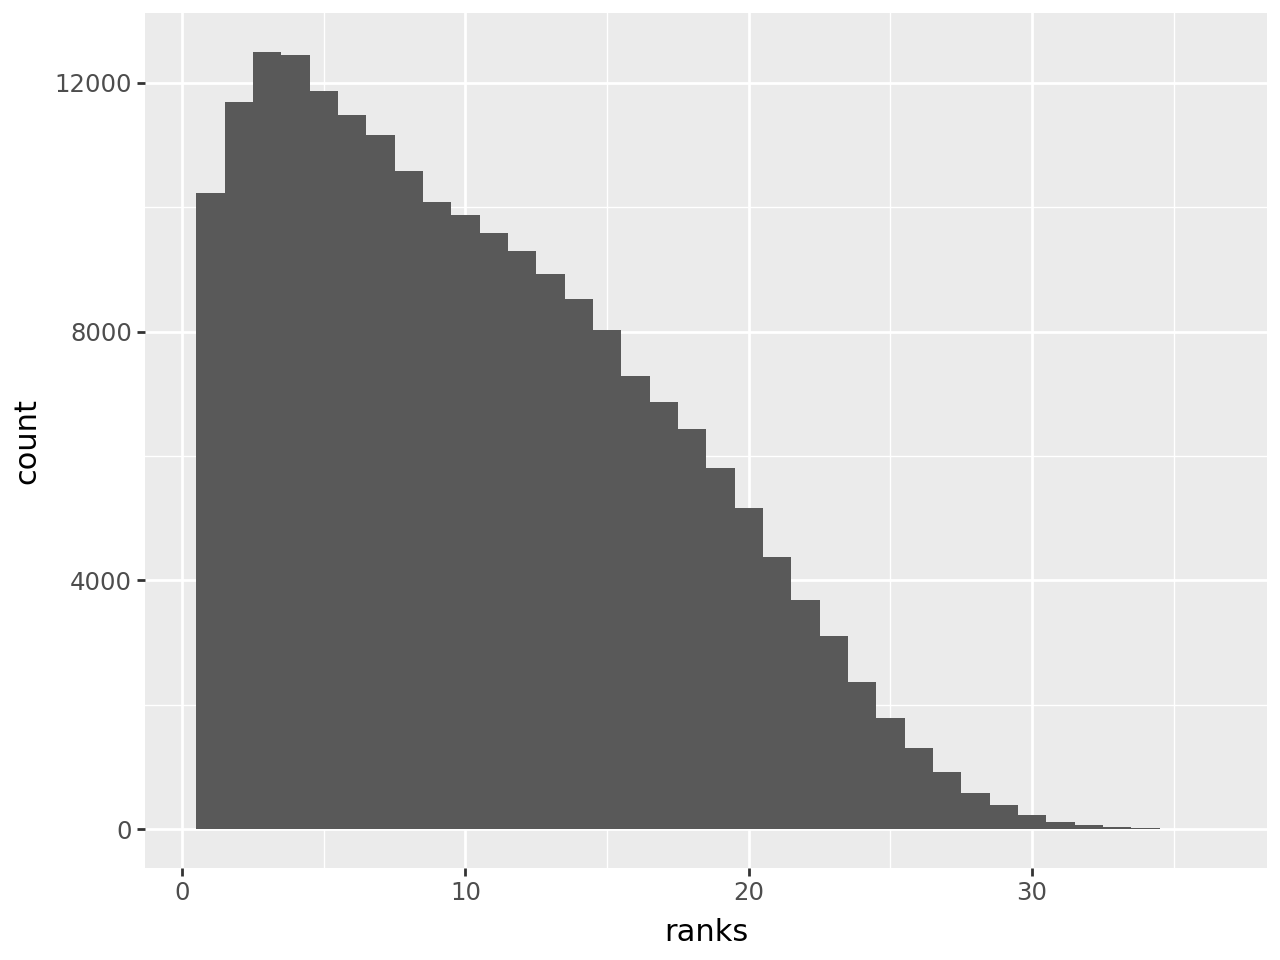

In [9]:
(
    p9.ggplot(icm, p9.aes(x="ranks"))
    + p9.geom_histogram(binwidth=1)
)

For further mining, we are only interested in the best performing configurations, i.e. the top Pareto ranks.

In [10]:
subdf = icm[icm.ranks <= 1]
subdf

size     etime  ranks
inputname            configurationID                           
Animation_1080P-01b3 12               0.067026  0.001311      1
                     14               0.070142  0.000000      1
                     19               0.058674  0.011796      1
                     58               0.003181  0.039318      1
                     68               0.000770  0.070773      1
...                                        ...       ...    ...
Vlog_720P-6d56       50               0.223844  0.010038      1
                     64               0.079784  0.021115      1
                     71               0.003678  0.027345      1
                     72               0.000000  0.033922      1
                     79               0.084493  0.010730      1

[10221 rows x 3 columns]

For the `mlxtend` itemset mining functionality, it is necessary to convert the dataset to onehot encoding.

In [11]:
def prepare(dataset):
    enc = OneHotEncoder(
        min_frequency=1,
        handle_unknown="infrequent_if_exist",
        sparse_output=False,
    )
    enc.fit(dataset)
    col_names = enc.get_feature_names_out()
    onehot_data = enc.transform(dataset)

    df = pd.DataFrame(onehot_data, columns=col_names, dtype=np.bool_)
    return df

dataset = subdf.join(config_features).join(input_features).reset_index()

df = prepare(dataset[config_features.columns])
print(f"One-hot encoded dataset has {df.shape[1]} columns ({dataset.shape[1]} before)")
df

One-hot encoded dataset has 78 columns (37 before)


,cabac_0,cabac_1,ref_1,ref_2,ref_3,ref_5,ref_7,ref_8,ref_16,subme_0,...,rc_lookahead_30.0,rc_lookahead_40.0,rc_lookahead_50.0,rc_lookahead_60.0,rc_lookahead_nan,scenecut_0.0,scenecut_40.0,scenecut_nan,weightb_1.0,weightb_nan
0,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,True
1,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,True
2,False,True,True,False,False,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,True
3,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
4,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10216,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
10217,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
10218,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
10219,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


In [12]:
subdf.shape, dataset.shape

((10221, 3), (10221, 37))

In [13]:
df2[["SPATIAL_COMPLEXITY", "TEMPORAL_COMPLEXITY", "CHUNK_COMPLEXITY_VARIATION", "COLOR_COMPLEXITY"]].round(2)

NameError: name 'df2' is not defined

In [ ]:
# Here we export the dataset for mining with choco-mining

df2 = subdf.join(config_features).join(input_features).reset_index()[list(input_features.columns) + ["configurationID"]]
stacked = df2.stack()
col_val_series = pd.Series([f'{i[1]}_{v}' for i, v in zip(stacked.index, stacked.values)])
# Factorize the stacked data
factorized_data, indices = pd.factorize(col_val_series)
mapping = {i: v for i, v in enumerate(indices)}
with open('mapping.json', 'w') as fp:
    json.dump(mapping, fp)

df2_encoded = factorized_data.reshape(df2.shape).astype(int)
df2_encoded = pd.DataFrame(df2_encoded, columns=df2.columns)

np.savetxt("transactions.dat", df2_encoded.values, fmt="%d")

df2_encoded

,resolution,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,category,configurationID
0,0,1,2,3,4,5,6,7,8
1,0,1,2,3,4,5,6,7,9
2,0,1,2,3,4,5,6,7,10
3,0,1,2,3,4,5,6,7,11
4,0,1,2,3,4,5,6,7,12
...,...,...,...,...,...,...,...,...,...
53933,442,443,444,354,3194,3195,2526,2909,98
53934,442,443,444,354,3194,3195,2526,2909,127
53935,442,443,444,354,3194,3195,2526,2909,104
53936,442,443,444,354,3194,3195,2526,2909,105


## FP-Growth
Extracting frequent itemsets from a dataset, i.e. which items to appear together most commonly.
We see that this gives us a lot of small itemsets, even though we are interested in the _largest_ partial configuration we can find.

In [ ]:
growthdf = fpgrowth(df, min_support=0.6, use_colnames=True).sort_values("support", ascending=False)
growthdf

,support,itemsets
0,1.000000,(qpmax_69)
1,0.903389,(me_range_16)
14,0.903389,"(me_range_16, qpmax_69)"
2,0.895287,(fast_pskip_1)
15,0.895287,"(fast_pskip_1, qpmax_69)"
...,...,...
88,0.606011,"(fast_pskip_1, trellis_0, ref_1)"
91,0.604917,"(fast_pskip_1, chroma_qp_offset_0, qpmax_69, r..."
89,0.604917,"(fast_pskip_1, chroma_qp_offset_0, ref_1)"
92,0.601135,"(mbtree_0, qpmax_69)"


## FP-Max 

FP-Max is a variant of FP-Growth, which focuses on obtaining maximal itemsets. 
An itemset X is said to maximal if X is frequent and there exists no frequent super-pattern containing X. 
In other words, a frequent pattern X cannot be sub-pattern of larger frequent pattern to qualify for the definition maximal itemset.

In [ ]:
maxsets = fpmax(df, min_support=0.2, use_colnames=True).sort_values("support", ascending=False)
maxsets["length"] = maxsets["itemsets"].apply(len)
maxsets

,support,itemsets,length
2214,0.260058,"(mixed_ref_0, me_range_16, chroma_qp_offset_0,...",10
71,0.237198,"(mixed_ref_1, me_range_16, qpmax_69)",3
1766,0.229875,"(mixed_ref_0, me_range_16, cabac_0, chroma_qp_...",10
997,0.227854,"(analyse_0x3:0x113, qpmax_69, 8x8dct_1, fast_p...",6
992,0.222923,"(analyse_0x3:0x113, 8x8dct_1, cabac_1, deblock...",5
...,...,...,...
491,0.200007,"(scenecut_0.0, weightp_0, fast_pskip_1, debloc...",8
1501,0.200007,"(scenecut_0.0, cabac_0, chroma_qp_offset_0, mb...",10
428,0.200007,"(scenecut_0.0, qpmax_69, direct_nan, trellis_0...",7
2323,0.200007,"(mixed_ref_0, chroma_qp_offset_0, aq-mode_1, 8...",7


In [ ]:
allinds = set()
itemsets = []
for i, r in enumerate(maxsets.itemsets):
    if allinds.issuperset(df[df[r].all(axis=1)].index):
        continue

    allinds.update(df[df[r].all(axis=1)].index)
    itemsets.append(r)
    print(i, len(allinds)/df.shape[0])

print(f"Covered {len(allinds)/df.shape[0]*100:.4f}% of the dataset with {len(itemsets)} configurations")

0 0.2600578441914791
1 0.49725610886573474
2 0.5463124327932071
3 0.6866587563498832
4 0.7122807668063332
5 0.7963217026956877
6 0.8405762171381957
7 0.8406503763580407
8 0.8493826244947903
10 0.8789165337980644
11 0.9150876932774668
13 0.9191479105639808
17 0.9195187066632059
18 0.9443435055063221
19 0.9456042122436872
20 0.9512773925618303
21 0.9546516370647781
22 0.9548184953094293
23 0.9632170269568764
28 0.9703733916719196
31 0.9741740516889762
32 0.9744150691534725
37 0.9808483814750268
92 0.984760280321851
110 0.9935110682635618
420 0.9964588972524009
590 0.9964774370573621
625 1.0
Covered 100.0000% of the dataset with 28 configurations


In [ ]:
allinds = set()
itemsets = []
for i, r in enumerate(maxsets.itemsets):
    covered_rows = df[r].all(axis=1).values
    if allinds.issuperset(dataset[covered_rows].inputname):
        continue

    allinds.update(dataset[covered_rows].inputname)
    itemsets.append(r)
    print(i, len(allinds)/dataset.inputname.nunique())

print(f"Covered {len(allinds)/dataset.inputname.nunique()*100:.4f}% of the inputs with {len(itemsets)} partial configurations")

0 1.0
Covered 100.0000% of the inputs with 1 partial configurations


In [ ]:
covered_rows = df[itemsets[0]].all(axis=1).values
static_features = dataset[covered_rows][config_features.columns].nunique() == 1
static_features = static_features[static_features].index.tolist()
variable_features = [c for c in config_features.columns if c not in static_features]
static_features

['ref',
 'mixed_ref',
 'me_range',
 'trellis',
 'fast_pskip',
 'chroma_qp_offset',
 'mbtree',
 'qpmax',
 'me',
 'b_adapt',
 'b_pyramid',
 'open_gop',
 'weightb']

In [ ]:
dataset[covered_rows].groupby(variable_features).count()

,,,,,,,,,,,inputname,configurationID,usertime,systemtime,etime,cpu,fps,kbs,ranks,ref,...,open_gop,weightb,resolution,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,category
cabac,subme,8x8dct,bframes,weightp,aq-mode,analyse,direct,deblock,rc_lookahead,scenecut,,,,,,,,,,,,,,,,,,,,,


In [ ]:
dataset[covered_rows][config_features.columns].nunique()[dataset[covered_rows][config_features.columns].nunique() > 1]

cabac       2
subme       4
8x8dct      2
bframes     3
weightp     3
aq-mode     2
analyse     3
direct      2
deblock     2
scenecut    2
dtype: int64

In [ ]:
cfg_columns = ["configurationID"] + list(config_features.columns)
top_cfgs = dataset[cfg_columns + ["inputname"]].groupby(cfg_columns, dropna=False, as_index=False).count().sort_values(
    "inputname", ascending=False
).configurationID.tolist()

In [ ]:
## Here we select the configurations by decreasing coverage
# If a configuration adds new items, we add it.
# We repeat until all inputs are covered.

covered_inputs = set()
num_inputs = subdf.reset_index().inputname.nunique()
input_labels = pd.Series(np.zeros(num_inputs), index=dataset.inputname.unique())
selected_configs = []

for cid in top_cfgs:
    inputnames = subdf.reset_index().query("configurationID == @cid").inputname.unique()
    new_inputs = set(inputnames).difference(covered_inputs)
    input_labels[list(new_inputs)] = cid
    covered_inputs.update(new_inputs)
    selected_configs.append(cid)

    if len(covered_inputs) == num_inputs:
        print(f"Reached full coverage with {len(selected_configs)} configurations")
        break


Reached full coverage with 5 configurations


In [ ]:
## Here we select the configurations by maximal gain
# We iterate over all open configurations and add that which adds the most input coverage.
# We repeat until all inputs are covered.
# The code could be more efficient, but it's good enough for x264

covered_inputs = set()
num_inputs = subdf.reset_index().inputname.nunique()
input_labels = pd.Series(np.zeros(num_inputs), index=dataset.inputname.unique())
selected_configs = []
open_cfg = np.ones(len(top_cfgs), dtype=np.bool_)

while len(covered_inputs)/num_inputs < 1.0:
    max_add = 0
    max_add_id = -1
    
    for i in np.where(open_cfg)[0]:
        cid = top_cfgs[i]
        inputnames = subdf.reset_index().query("configurationID == @cid").inputname.unique()
        new_inputs = set(inputnames).difference(covered_inputs)
    
        if len(new_inputs) == 0:
            open_cfg[i] = False

        if len(new_inputs) > max_add:
            max_add = len(new_inputs)
            max_add_id = i

    cid = top_cfgs[max_add_id]
    inputnames = subdf.reset_index().query("configurationID == @cid").inputname.unique()
    new_inputs = set(inputnames).difference(covered_inputs)
    input_labels[list(new_inputs)] = cid
    open_cfg[max_add_id] = False
    covered_inputs.update(new_inputs)
    selected_configs.append(cid)

    print(len(covered_inputs)/num_inputs)

print(f"Reached full coverage with {len(selected_configs)} configurations")

0.9290573372206026
0.9941690962099126
1.0
Reached full coverage with 3 configurations


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

input_labels = input_labels.sort_index()
enc = LabelEncoder()
y = enc.fit_transform(input_labels)

X = input_preprocessor.fit_transform(
    input_features.query("inputname.isin(@input_labels.index)").sort_index()
)

train_idx, val_idx = train_test_split(
    np.arange(X.shape[0]), test_size=0.2, random_state=random_state
)
X_train = X[train_idx]
X_val = X[val_idx]
y_train = y[train_idx]
y_val = y[val_idx]
inputnames_val = input_labels.index[val_idx]

# X_train = X
# y_train = y
# X_val = X
# y_val = y
# inputnames_val = input_labels.index

best_val_rank = -100_000
best_depth = 0

for i in range(1, X.shape[1]):
    print(i)
    clf = DecisionTreeClassifier(max_depth=i)
    # clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    val_score = clf.score(X_val, y_val)
    print("Scores", clf.score(X_train, y_train), val_score)

    # Validation test
    pred_cfg_lbl = clf.predict(X_val)
    pred_cfg = enc.inverse_transform(pred_cfg_lbl).astype(int)
    inp_pred_map = pd.DataFrame(
        zip(inputnames_val, pred_cfg), columns=["inputname", "configurationID"]
    )
    val_rank = icm.merge(inp_pred_map, on=["inputname", "configurationID"])[
        "ranks"
    ].mean()
    print("Val rank", val_rank)

    if val_rank < best_val_rank:
        best_val_rank = val_score
        best_depth = i

print(f"Best depth {best_depth}")
clf = DecisionTreeClassifier(max_depth=best_depth)
# clf = RandomForestClassifier()
clf.fit(X, y)
pred_cfg_lbl = clf.predict(X)
pred_cfg = enc.inverse_transform(pred_cfg_lbl).astype(int)

print("Scores", clf.score(X, y))

# Validation test
inp_pred_map = pd.DataFrame(
    zip(inputnames_val, pred_cfg), columns=["inputname", "configurationID"]
)
val_rank = icm.merge(inp_pred_map, on=["inputname", "configurationID"])["ranks"].mean()
print("Val rank", val_rank)

# Test set
X_test = input_preprocessor.transform(input_features.query("inputname.isin(@test_inp)"))
pred_cfg = enc.inverse_transform(clf.predict(X_test)).astype(int)

inp_pred_map = pd.DataFrame(
    zip(test_inp, pred_cfg), columns=["inputname", "configurationID"]
)
print(
    "Test rank",
    icm_test.merge(inp_pred_map, on=["inputname", "configurationID"])["ranks"].mean(),
)
print("")

1
Scores 0.519180470793374 0.5174216027874564
2
Scores 0.6159546643417612 0.6045296167247387
3
Scores 0.7428073234524848 0.7386759581881533
4
Scores 0.8400174367916303 0.8327526132404182
5
Scores 0.8731473408892764 0.8623693379790941
6
Scores 0.9128160418482999 0.8832752613240418
7
Scores 0.9306887532693985 0.9146341463414634
8
Scores 0.944202266782912 0.921602787456446
9
Scores 0.9664341761115954 0.9407665505226481
10
Scores 0.9712292938099389 0.9425087108013938
11
Scores 0.9742807323452485 0.9407665505226481
12
Scores 0.980819529206626 0.9407665505226481
13
Scores 0.9882301656495205 0.9477351916376306
14
Scores 0.9952048823016565 0.9512195121951219
15
Scores 0.9978204010462075 0.9494773519163763
16
Scores 0.9995640802092415 0.9442508710801394
17
Scores 1.0 0.9529616724738676
18
Scores 1.0 0.9494773519163763
19
Scores 1.0 0.9477351916376306
20
Scores 1.0 0.9547038327526133
Best depth 20
Scores 1.0
Val rank 1.0
Test rank 1.065891472868217



In [ ]:
clf = DecisionTreeClassifier(max_depth=500)
# clf = RandomForestClassifier()
clf.fit(X, y)

DecisionTreeClassifier(max_depth=500)

In [ ]:
sdf = subdf.join(input_features).reset_index()
crit = sdf["WIDTH"] < 1920
sdf[crit].shape, sdf[~crit].shape

((36110, 17), (17828, 17))

In [ ]:
inp_l = sdf[crit].inputname.unique().tolist()
inp_r = sdf[~crit].inputname.unique().tolist()
len(inp_l), len(inp_r)

(676, 353)

In [ ]:
# TODO Match left and right side to the most common configurations without having each configuration being assigned on both sides
# The imbalance criterion is the difference between number of configurations needed
# Extended version: Run it two times, each starting with the other side
# Next step: Build tree with different sizes -> For this we need a custom decision tree implementation resp. must look up the splitter from scikit-learn

In [ ]:
sdf[crit].groupby("configurationID").count().sort_values("usertime", ascending=False)

,inputname,usertime,systemtime,etime,cpu,fps,kbs,ranks,resolution,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,category
configurationID,,,,,,,,,,,,,,,,
43,638,638,638,638,638,638,638,638,638,638,638,638,638,638,638,638
13,626,626,626,626,626,626,626,626,626,626,626,626,626,626,626,626
45,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613,613
49,609,609,609,609,609,609,609,609,609,609,609,609,609,609,609,609
44,609,609,609,609,609,609,609,609,609,609,609,609,609,609,609,609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
148,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
201,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [ ]:
sdf[~crit].groupby("configurationID").count().sort_values("usertime", ascending=False)

,inputname,usertime,systemtime,etime,cpu,fps,kbs,ranks,resolution,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,category
configurationID,,,,,,,,,,,,,,,,
13,330,330,330,330,330,330,330,330,330,330,330,330,330,330,330,330
21,325,325,325,325,325,325,325,325,325,325,325,325,325,325,325,325
17,325,325,325,325,325,325,325,325,325,325,325,325,325,325,325,325
30,320,320,320,320,320,320,320,320,320,320,320,320,320,320,320,320
19,317,317,317,317,317,317,317,317,317,317,317,317,317,317,317,317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
149,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
159,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
from sklearn.tree import _tree

# This is from the DaL code
def recursive_dividing(node, depth, tree_, X, samples=[], max_depth=1, min_samples=2, cluster_indexes_all=[]):
    indent = "  " * depth
    if depth <= max_depth:
        if tree_.feature[node] != _tree.TREE_UNDEFINED:  # if it's not the leaf node
            left_samples = []
            right_samples = []
            # get the node and the dividing threshold
            name = tree_.feature[node]
            threshold = tree_.threshold[node]
            # split the samples according to the threshold
            for i_sample in range(0, len(samples)):
                if X[i_sample, name] <= threshold:
                    left_samples.append(samples[i_sample])
                else:
                    right_samples.append(samples[i_sample])
            # check if the minimum number of samples is statisfied
            if (len(left_samples) <= min_samples or len(right_samples) <= min_samples):
                print('{}Not enough samples to cluster with {} and {} samples'.format(indent,
                                                                                      len(left_samples),
                                                                                      len(right_samples)))
                cluster_indexes_all.append(samples)
            else:
                print("{}{} samples with feature {} <= {}:".format(indent, len(left_samples), name,
                                                                   threshold))
                cluster_indexes_all = recursive_dividing(tree_.children_left[node], depth + 1, tree_, X, left_samples, max_depth, min_samples, cluster_indexes_all)
                print("{}{} samples with feature {} > {}:".format(indent, len(right_samples), name,
                                                                  threshold))
                cluster_indexes_all = recursive_dividing(tree_.children_right[node], depth + 1, tree_, X, right_samples, max_depth, min_samples, cluster_indexes_all)
        else:
            cluster_indexes_all.append(samples)
    # the base case: add the samples to the cluster
    elif depth == max_depth + 1:
        cluster_indexes_all.append(samples)
    return cluster_indexes_all

recursive_dividing(0, 1, clf.tree_, X, np.arange(X.shape[0]), 2)

  205 samples with feature 18 <= 0.14900000393390656:
    8 samples with feature 19 <= 0.11299999803304672:
    197 samples with feature 19 > 0.11299999803304672:
  824 samples with feature 18 > 0.14900000393390656:
    745 samples with feature 0 <= 0.5:
    79 samples with feature 0 > 0.5:


[[0, 49, 118, 132, 312, 334, 370, 433],
 [2,
  4,
  5,
  9,
  11,
  12,
  17,
  18,
  31,
  34,
  36,
  39,
  46,
  48,
  51,
  58,
  64,
  65,
  72,
  84,
  88,
  97,
  98,
  101,
  102,
  103,
  104,
  105,
  115,
  120,
  122,
  123,
  127,
  146,
  156,
  168,
  169,
  188,
  189,
  193,
  194,
  210,
  227,
  229,
  232,
  235,
  237,
  238,
  246,
  252,
  254,
  258,
  265,
  278,
  282,
  286,
  288,
  294,
  296,
  299,
  301,
  302,
  305,
  306,
  308,
  309,
  310,
  311,
  314,
  317,
  318,
  319,
  323,
  324,
  325,
  333,
  335,
  338,
  340,
  343,
  348,
  355,
  356,
  360,
  363,
  366,
  368,
  369,
  371,
  372,
  373,
  375,
  378,
  379,
  380,
  381,
  386,
  387,
  393,
  394,
  395,
  396,
  400,
  401,
  403,
  412,
  413,
  414,
  420,
  422,
  425,
  450,
  455,
  458,
  460,
  470,
  476,
  488,
  493,
  495,
  498,
  499,
  500,
  507,
  509,
  510,
  511,
  512,
  513,
  515,
  519,
  522,
  528,
  530,
  531,
  535,
  560,
  561,
  564,
  570,
  604,


In [ ]:
## These are our evaluation baselines
# The best configuration by averaging the ranks over all inputs
best_cfg_id_overall = icm[["ranks"]].groupby("configurationID").mean().idxmin().item()

# The best configuration per performance metric
best_cfg_id_per_metric = icm_ranked_measures.groupby("configurationID").mean().idxmin()

# The most common configuration in the Pareto fronts
most_common_cfg_id = (
    dataset[["configurationID"] + [config_features.columns[0]]]
    .groupby(["configurationID"], as_index=False)
    .count()
    .sort_values(by=config_features.columns[0], ascending=False)
    .iloc[0]
    .configurationID
)

In [ ]:
overall_ranks = icm_test.query("configurationID == @best_cfg_id_overall").ranks
print(f"Average rank of the overall best configuration: {overall_ranks.mean():.2f}+-{overall_ranks.std():.2f}")

for p in performances:
    cfg_id = best_cfg_id_per_metric[p]
    overall_ranks = icm_test.query("configurationID == @cfg_id").ranks
    print(f"Average rank of the best configuration for {p}: {overall_ranks.mean():.2f}+-{overall_ranks.std():.2f}")

overall_ranks = icm_test.query("configurationID.isin(@best_cfg_id_per_metric.values)").ranks
print(f"Average rank of the best configuration for all metrics: {overall_ranks.mean():.2f}+-{overall_ranks.std():.2f}")

overall_ranks = icm_test.query("configurationID == @most_common_cfg_id").ranks
print(f"Average rank of the most common configuration: {overall_ranks.mean():.2f}+-{overall_ranks.std():.2f}")

# TODO Not sure std. dev. is correct here. We sample all random configs at once.
random_ranks = np.random.randint(0, test_perf.configurationID.max(), 10) + 1
overall_ranks = icm_test.query("configurationID.isin(@random_ranks)").ranks
print(f"Average rank of random configuration: {overall_ranks.mean():.2f}+-{overall_ranks.std():.2f}")


Average rank of the overall best configuration: 2.10+-1.84
Average rank of the best configuration for size: 3.60+-3.17
Average rank of the best configuration for etime: 3.95+-2.25
Average rank of the best configuration for all metrics: 3.78+-2.75
Average rank of the most common configuration: 3.07+-2.96
Average rank of random configuration: 12.21+-6.57


In [ ]:
part_dataset = dataset[(dataset.COLOR_COMPLEXITY < 0.01) & (dataset.CHUNK_COMPLEXITY_VARIATION < 0.008)]

if part_dataset[input_features.columns].drop_duplicates().shape[0] == 1:
    print("Constant dataframe")

cdf = prepare(part_dataset[config_features.columns])
maxsets = fpmax(cdf, min_support=0.6, use_colnames=True).sort_values("support", ascending=False)
maxsets["length"] = maxsets["itemsets"].apply(len)
maxsets["num_measurements"] = maxsets["support"] * cdf.shape[0]
maxsets

## Open Questions

- How do the itemsets change if we partition the data? E.g. by input features like category
- How do the itemsets change if we vary the pareto rank?
- What will we observe on the other datasets?
- What do we take away from the results?
- How can it be presented?

Orthogonal to the question of "What configuration options appear the most in the Pareto fronts" is the question of "What full configurations are the most common in the Pareto fronts":
This we should be able to answer by looking at the largest itemset we can find; here it's interesting to compare it's length to the number of configuration options.